In [1]:
import os
os.chdir('../')

In [2]:
import numpy as np
import torch
from torchvision.transforms import Compose
from torch.utils.data import DataLoader
import torch.nn.functional as F
from einops.layers.torch import Rearrange

from src.opts.opts import parser
from src.models.conv_ae_with_memory import ConvAEMemory
from src.dataset.video_dataset_ae import VideoDataset, prepare_clips_data
from src.dataset.video_transforms import (
    GroupMultiScaleCrop,
    Stack, 
    ToTorchFormatTensor, 
    GroupNormalize,
)

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

%load_ext autoreload
%autoreload 2

In [3]:
args = parser.parse_args([])
args.__dict__

{'holoassist_dir': '/Users/artemmerinov/data/holoassist',
 'raw_annotation_file': '/Users/artemmerinov/data/holoassist/data-annotation-trainval-v1_1.json',
 'split_dir': '/Users/artemmerinov/data/holoassist/data-splits-v1',
 'fine_grained_actions_map_file': '/Users/artemmerinov/data/holoassist/fine_grained_actions_map.txt',
 'dataset_name': 'holoassist',
 'num_segments': 8,
 'num_epochs': 10,
 'batch_size': 16,
 'lr': 0.01,
 'clip_gradient': None,
 'num_workers': 4,
 'memory_size': 32,
 'memory_dim': 512}

In [4]:
clip_path_to_video_arr, clip_start_arr, clip_end_arr, clip_is_anomaly_arr = prepare_clips_data(
    raw_annotation_file=args.raw_annotation_file,
    holoassist_dir=args.holoassist_dir, 
    split_dir=args.split_dir,
    fine_grained_actions_map_file=args.fine_grained_actions_map_file,
    mode="validation",
    anomaly_mode="both",
)

transform = Compose([
    GroupMultiScaleCrop(input_size=224, scales=[1, .875]),
    Stack(),
    ToTorchFormatTensor(div=True),
    GroupNormalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dataset = VideoDataset(
    clip_path_to_video_arr=clip_path_to_video_arr,
    clip_start_arr=clip_start_arr,
    clip_end_arr=clip_end_arr,
    clip_is_anomaly_arr=clip_is_anomaly_arr,
    num_segments=args.num_segments,
    transform=transform,
    mode="validation"
)

dataloader = DataLoader(
    dataset=dataset, 
    batch_size=args.batch_size, 
    shuffle=False,
    num_workers=args.num_workers, 
    drop_last=False, 
    pin_memory=False
)

There are 213 videos in the list There are 13 videos as video files There are 206 videos that present in the list but are missing as videos.
Number of clips: 470 for mode validation
Number of normal clips: 454 for mode validation
Number of anomalous clips: 16 for mode validation


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ConvAEMemory(input_channels=args.num_segments * 3).to(device)
model = torch.nn.DataParallel(model).to(device)

In [42]:
checkpoint = torch.load(f='checkpoints/AE_02.pth', map_location=torch.device(device))
state_dict = checkpoint['model_state_dict']
model.load_state_dict(state_dict=state_dict)
model.eval();

memory = np.load('checkpoints/memory_02.npy')
memory = torch.Tensor(memory).to(device)

In [43]:
memory

tensor([[-0.0359, -0.0206, -0.0257,  ..., -0.0291,  0.0016,  0.0181],
        [-0.0335, -0.0133,  0.0096,  ..., -0.0637,  0.0636,  0.0191],
        [ 0.0393,  0.0285,  0.0239,  ...,  0.0585, -0.0163,  0.0016],
        ...,
        [-0.0307,  0.0024, -0.0430,  ...,  0.0263, -0.0725,  0.0053],
        [ 0.0443,  0.0077,  0.0702,  ...,  0.0530, -0.0767,  0.0484],
        [-0.0364, -0.0171, -0.0024,  ..., -0.0577,  0.0464,  0.0173]])

In [48]:
x, y = dataset[252]

x = Rearrange("(t c) h w -> 1 (t c) h w", t=args.num_segments, c=3, h=224, w=224)(x)
x = x.to(device)
x_hat, queries, augmented_queries, memory, score_query, score_memory, gathering_loss, spreading_loss = model(x, memory, train=False)

In [45]:
memory

tensor([[-0.0359, -0.0206, -0.0257,  ..., -0.0291,  0.0016,  0.0181],
        [-0.0335, -0.0133,  0.0096,  ..., -0.0637,  0.0636,  0.0191],
        [ 0.0393,  0.0285,  0.0239,  ...,  0.0585, -0.0163,  0.0016],
        ...,
        [-0.0307,  0.0024, -0.0430,  ...,  0.0263, -0.0725,  0.0053],
        [ 0.0443,  0.0077,  0.0702,  ...,  0.0530, -0.0767,  0.0484],
        [-0.0364, -0.0171, -0.0024,  ..., -0.0577,  0.0464,  0.0173]])

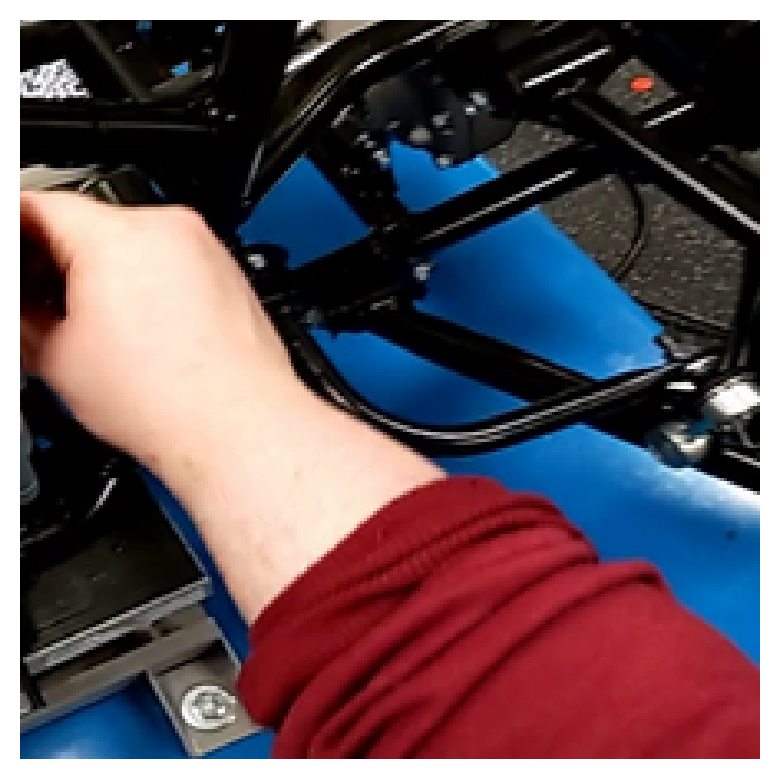

In [46]:
rearranged_x = Rearrange("n (t c) h w -> (n t) h w c", t=args.num_segments, c=3, h=224, w=224)(x)
img = rearranged_x[0]
img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
img = np.clip(img, 0, 1)

plt.imshow(img);
plt.axis('off');

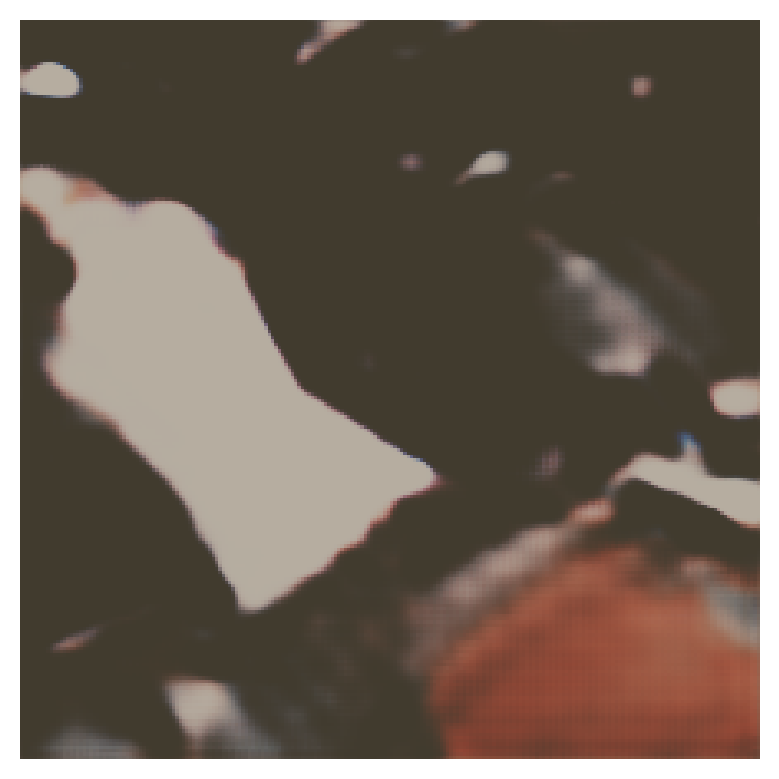

In [47]:
rearranged_x_hat = Rearrange("n (t c) h w -> (n t) h w c", t=args.num_segments, c=3, h=224, w=224)(x_hat).detach()

img = rearranged_x_hat[0]
img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
img = np.clip(img, 0, 1)

plt.imshow(img);
plt.axis('off');